In [1]:
import Pkg
Pkg.activate(@__DIR__)

  Activating project at `~/Developer/analyze-iris`


In [2]:
using Revise, JSON, Dates, Plots, StatsBase, TimeZones

In [3]:
@userplot StackedArea

# a simple "recipe" for Plots.jl to get stacked area plots
# usage: stackedarea(xvector, datamatrix, plotsoptions)
@recipe function f(pc::StackedArea)
    x, y = pc.args
    n = length(x)
    y = cumsum(y, dims=2)
    seriestype := :shape

    # create a filled polygon for each item
    for c=1:size(y,2)
        sx = vcat(x, reverse(x))
        sy = vcat(y[:,c], c==1 ? zeros(n) : reverse(y[:,c-1]))
        @series (sx, sy)
    end
end

In [4]:
struct Reservation
    name::String
    nodelist::String
    starttime::String
    endtime::String
    nodecount::Int64
    features::String
    acccount::String
end

In [5]:
ue_seconds(x::String) = Int64(
    floor(datetime2unix(
            DateTime(ZonedDateTime(
                DateTime(x, "yyyy-mm-ddTHH:MM:SS"),
                tz"America/Los_Angeles")
                , UTC
            )
    ))
)
start(r::Reservation)  = ue_seconds(r.starttime)
finish(r::Reservation) = ue_seconds(r.endtime)

finish (generic function with 1 method)

In [6]:
moving_average(vs,n) = [sum(@view vs[i:(i+n-1)])/n for i in 1:(length(vs)-(n-1))]

moving_average (generic function with 1 method)

In [7]:
nid_list_start(x::AbstractString) = occursin("[", x) ? findfirst("[", x)[1] + 1 : 4
nid_list_end(x::AbstractString) = occursin("[", x) ? findfirst("]", x)[1] - 1 : length(x)
nid_list(x::AbstractString) = x[nid_list_start(x):nid_list_end(x)]

function nids(x::AbstractString)
    nids = Int64[]
    r = split(nid_list(x), ",")
    for sr in r
        s = split(sr, "-")
        if length(s) < 2
            push!(nids, parse(Int64, s[1]))
        else
            a, b = s
            append!(nids, collect(parse(Int64, a) : parse(Int64, b)))
        end
    end
    return nids
end

nids(r::Reservation) = nids(r.nodelist)

nids (generic function with 2 methods)

In [8]:
struct Job
    id::Int64
    startTime::Int64
    endTime::Int64
    submitTime::Int64
    jobAccount::String
    allocCpus::Int64
    allocNodes::Int64
    qos::String
    name::String
    nodes::Vector{Int64}
    partition::String

    function Job(job::Dict{String, Any})
        new(
            job["jobId"],
            job["startTime"],
            job["endTime"],
            job["submitTime"],
            job["jobAccount"],
            job["allocCpus"],
            job["allocNodes"],
            job["qos"],
            job["name"],
            nids(job["nodes"]),
            job["partition"]
        )
    end
    Job(args...) = new(args...)
end

id(j::Job)        = j.id
start(j::Job)     = j.startTime
finish(j::Job)    = j.endTime
submit(j::Job)    = j.submitTime
account(j::Job)   = j.jobAccount
cpus(j::Job)      = j.allocCpus
nodes(j::Job)     = j.allocNodes
qos(j::Job)       = j.qos
name(j::Job)      = j.name
nids(j::Job)      = j.nodes
partition(j::Job) = j.partition

duration(j::Job) = finish(j) - start(j)
waittime(j::Job) = start(j) - submit(j)

function Job(j::Job, r::Reservation)
    
    res_nodes = intersect(nids(j), nids(r))
    
    if length(nids(j)) == length(res_nodes)
        return j
    end

    n = cpus(j) / nodes(j)

    Job(
        id(j),
        start(j),
        finish(j),
        submit(j),
        account(j),
        length(res_nodes)*n,
        length(res_nodes),
        qos(j),
        name(j),
        res_nodes,
        partition(j)
    )
end

Job

In [9]:
function partitions(jobs::Array{Job})
    partitions = String[]
    for j in jobs
        if !(partition(j) in partitions)
            push!(partitions, partition(j))
        end
    end
    return partitions
end

import Base.get

function get(jobs::Array{Job}, ID::Integer)
    for j in jobs
        if id(j) == ID
            return j
        end
    end
end

function get(jobs::Array{Dict{String, Any}}, ID::Integer)
    for j in jobs
        if j["jobId"] == ID
            return j
        end
    end
end

get (generic function with 77 methods)

In [10]:
struct History
    compute::Vector{Int64}
    waiting::Vector{Int64}
    nodes::Dict{Int64, Vector{Int64}}
    start::Int64
    finish::Int64
    
    function History(r::Reservation)
        s = start(r)
        f = finish(r)

        compute = zeros(Int64, f - s)
        waiting = zeros(Int64, f - s)
        nodes = Dict{Int64, Vector{Int64}}()
        for n in nids(r)
            nodes[n] = zeros(Int64, f - s)
        end

        new(compute, waiting, nodes, s, f)
    end
end

function add!(h::History, j::Job)
    start_job = max(h.start, start(j)) - h.start + 1
    end_job   = min(h.finish, finish(j)) - h.start

    n_cpus = cpus(j)
    for sec = start_job:end_job
        h.compute[sec] += n_cpus
    end
    
    cpus_per_node = n_cpus/nodes(j)
    
    for nid in nids(j)
        for sec = start_job:end_job
            h.nodes[nid][sec] += cpus_per_node
        end
    end
    
    submit_job = max(h.start, submit(j)) - h.start + 1
    
    for sec = submit_job:min(start_job, h.finish - h.start)
        h.waiting[sec] += n_cpus
    end
end

function max_node(h::History)
    m = 0
    for k in keys(h.nodes)
        m = max(m, maximum(h.nodes[k]))
    end
    return m
end 

max_node (generic function with 1 method)

In [11]:
reservations = Dict(
    "lx31_1"  => Reservation(
        "lx31_processing_1",
        "nid00[800-831]",
        "2021-07-23T10:00:00", "2021-07-23T22:00:00",
        32, "haswell", "lcls"
    ),
    "lx31_1a" => Reservation(
        "lx31_processing_1a", 
        "nid0[1161,1203-1205,1330-1332,1393-1403,1423-1426,1454-1460,1463-1464,1492]",
        "2021-07-23T23:07:19", "2021-07-24T11:07:19",
        32, "haswell", "lcls"
    ),
    "lx31_2"  => Reservation(
        "lx31_processing_2",
        "nid0[0792,0800-0808,0810-0811,0813-0831,0845,1325-1326,1929-1931,1969,2010,2013,2018,2026-2027,2081-2084,2105-2106,2146-2147,2150-2151,2161,2219,2221-2225,2228,2293-2295]",
        "2021-07-25T10:00:00", "2021-07-26T10:00:00",
        64, "haswell", "lcls"
    ),
    "lv07_1"  => Reservation(
        "lv07_processing_1",
        "nid00[792-795,800-831,845,847-848,852-876]",
        "2021-07-29T10:00:00", "2021-07-29T22:00:00",
        64, "haswell", "lcls"
    ),
    "lv07_2"  => Reservation(
        "lv07_processing_2",
        "nid00[792-795,800-831,845,847-848,852-876]",
        "2021-07-30T10:00:00", "2021-07-30T22:00:00",
        64, "haswell", "lcls"),
    "lv07_3"  => Reservation(
        "lv07_processing_3",
        "nid00[792-795,800-831,845,847-848,852-876]",
        "2021-07-31T10:00:00", "2021-07-31T22:00:00",
        64, "haswell", "lcls"),
    "lv07_4"  => Reservation(
        "lv07_processing_4",
        "nid00[792-795,800-831,845,847-848,852-876]",
        "2021-08-01T10:00:00", "2021-08-01T22:00:00",
        64, "haswell", "lcls"),
    "p203_1"  => Reservation(
        "p203_processing_1",
        "nid00[792-795,800-827]",
        "2021-08-01T22:00:00", "2021-08-02T10:00:00",
        32, "haswell", "lcls"),
    "p203_2"  => Reservation(
        "p203_processing_2",
        "nid00[792-795,800-827]",
        "2021-08-02T22:00:00", "2021-08-03T12:00:00",
        32, "haswell", "lcls"),
    "p203_3"  => Reservation(
        "p203_processing_2",
        "nid00[792-795,800-828,860,876-882,884,902-910,913-914,924-926,928-929,935,947-949,952-953]",
        "2021-08-02T22:00:00", "2021-08-03T12:00:00",
        64, "haswell", "lcls")
)

Dict{String, Reservation} with 10 entries:
  "lv07_2"  => Reservation("lv07_processing_2", "nid00[792-795,800-831,845,847-…
  "lv07_4"  => Reservation("lv07_processing_4", "nid00[792-795,800-831,845,847-…
  "lv07_1"  => Reservation("lv07_processing_1", "nid00[792-795,800-831,845,847-…
  "lv07_3"  => Reservation("lv07_processing_3", "nid00[792-795,800-831,845,847-…
  "p203_2"  => Reservation("p203_processing_2", "nid00[792-795,800-827]", "2021…
  "lx31_1"  => Reservation("lx31_processing_1", "nid00[800-831]", "2021-07-23T1…
  "p203_1"  => Reservation("p203_processing_1", "nid00[792-795,800-827]", "2021…
  "lx31_1a" => Reservation("lx31_processing_1a", "nid0[1161,1203-1205,1330-1332…
  "lx31_2"  => Reservation("lx31_processing_2", "nid0[0792,0800-0808,0810-0811,…
  "p203_3"  => Reservation("p203_processing_2", "nid00[792-795,800-828,860,876-…

In [12]:
lx31_jobs = open(joinpath("data", "sacct", "lx31_jobs.json"), "r") do f
    JSON.parse(f)
end

lv07_jobs = open(joinpath("data", "sacct", "lv07_jobs.json"), "r") do f
    JSON.parse(f)
end

p203_jobs = open(joinpath("data", "sacct", "p203_jobs.json"), "r") do f
    JSON.parse(f)
end

admin_comments = merge(lx31_jobs, lv07_jobs, p203_jobs)
admin_comments_flat = Dict{String, Any}[]
jobs = Dict{String, Vector{Any}}()
jobs_flat = Job[]
for res in keys(admin_comments)
    if res == "p203_2"
        println("Skipping $(res)")
        continue
    end
    
    jobs[res] = Job[]
    for job in admin_comments[res]
        j = Job(job)
        j_int = Job(j, reservations[res])
        push!(jobs[res], j_int)
        push!(jobs_flat, j_int)
        push!(admin_comments_flat, job)
    end
end

Skipping p203_2


In [13]:
add_all!(h::History, ac::String, jobs::Array{Any}) = broadcast(
        x->add!(h, x),
        filter(
            x->account(x) == ac,
            jobs
        )
    );

h_lcls = Dict{String,History}()
for res in keys(reservations)
    if res == "p203_2"
        println("Skipping $(res)")
        continue
    end
    
    h_lcls[res] = History(reservations[res])
    add_all!(h_lcls[res], "lcls", jobs[res])
end

h_nstaff = Dict{String,History}()
for res in keys(reservations)
    if res == "p203_2"
        println("Skipping $(res)")
        continue
    end
    
    h_nstaff[res] = History(reservations[res])
    add_all!(h_nstaff[res], "nstaff", jobs[res])
end

h_other = Dict{String,History}()
for res in keys(reservations)
    if res == "p203_2"
        println("Skipping $(res)")
        continue
    end
    
    h_other[res] = History(reservations[res])
    broadcast(
        x->add!(h_other[res], x),
        filter(
            x->(account(x)!="lcls") && (account(x)!="nstaff"),
            jobs[res]
        )
    );
end

Skipping p203_2
Skipping p203_2
Skipping p203_2


In [23]:
function select(r, dx, dy)
    if r == :all
        return dx, dy
    else
        return dx[(dx.>r[1]).&(dx.<r[2])], dy[(dx.>r[1]).&(dx.<r[2])]
    end
end

function line_plot(h1, h1s, h1o, r=:all)
    
    l = @layout [[a ; b{0.33h}] c{0.40w}]

    x  = range(h1.start, h1.finish-1, step=1)/60/60

    x1, y1 = select(r, x.-x[1], h1.compute/64)
    plot(
        x1, y1,
        label = "lcls running", legend = false,
        linewidth = 2, xaxis = nothing, showaxis = :y, grid = false,
        ylabel = "Haswell Nodes Used"
    )
    x1, y2 = select(r, x.-x[1], (h1s.compute + h1o.compute)/64) 
    p1 = plot!(
        x1, y2,
        label = "preemptible running",
        linewidth=2
    )
    x1, y3 = select(r, x.-x[1], (h1.waiting)/64) 
    plot(
        x1, y3,
        label = "lcls waiting", color=3,
        linewidth = 2, legend = false, grid = false,
        ylabel = "Nodes Queued", xlabel = "Time [h]",
        leftmargin=1.5Plots.cm, rightmargin=1.5Plots.cm, bottommargin=0.8Plots.cm
    )
        
    x1, y4 = select(r, x.-x[1], (h1s.compute + h1o.compute)/64) 
    p2 = plot!(
        twinx(),
        x1, y4,
        label = "preemptible running", color = 2,
        linewidth = 2, legend = false, grid = false,
        ylabel = "Preempible Nodes", # xlabel = "Time [h]"
    )

    plot([], label = "lcls running", color = 1)
    plot!([], label = "preemptible", color = 2)
    plot!([], label = "lcls waiting", color = 3)
    p3 = plot!([], label="", grid = false, axis=nothing, showaxis=false, legend=(-0.1,0.8))

    return plot(p1, p2, p3, layout=l)
end

function stack_plot(h1, h1s, h1o, r=:all; borders=false)

    l = @layout [[a ; b{0.33h}] c{0.40w}]

    x  = range(h1.start, h1.finish - 1, step = 1)/60/60

    s_names = ["lcls running", "preemptible running"]

    x1, y1 = select(r, x.-x[1], h1.compute/64)
    x1, y2 = select(r, x.-x[1], (h1s.compute + h1o.compute)/64)

    lw = 0
    if borders
        lw = 0.01
    end
    
    p1 = stackedarea(
        x1, hcat(y1, y2), 
        labels = reshape(s_names, (1,2)), legend = false,
        linewidth = lw, xaxis = nothing, showaxis = :y, grid = false,
        ylabel = "Haswell Nodes Used"
    )

    x1, y3 = select(r, x.-x[1], h1.waiting/64)
    plot(
        x1, y3,
        label = "lcls waiting", color = 3,
        linewidth = 2, legend = false, grid = false,
        ylabel = "Nodes Queued", xlabel = "Time [h]",
        leftmargin=1.5Plots.cm, rightmargin=1.5Plots.cm, bottommargin=0.8Plots.cm
    )

    x1, y4 = select(r, x.-x[1], (h1s.compute + h1o.compute)/64) 
    p2 = plot!(
        twinx(),
        x1, y4,
        label = "preemptible running", color = 2,
        linewidth = 2, legend = false, grid = false,
        ylabel = "Preempible Nodes", # xlabel = "Time [h]"
    )

    plot([], label = "lcls running", color = 1)
    plot!([], label = "preemptible", color = 2)
    plot!([], label = "lcls waiting", color = 3)
    p3 = plot!([], label="", grid = false, axis=nothing, showaxis=false, legend=(-0.1,0.8))
    
    return plot(p1, p2, p3, layout=l)
end

stack_plot (generic function with 2 methods)

In [24]:
default(size=(1200, 400), thickness_scaling=1)

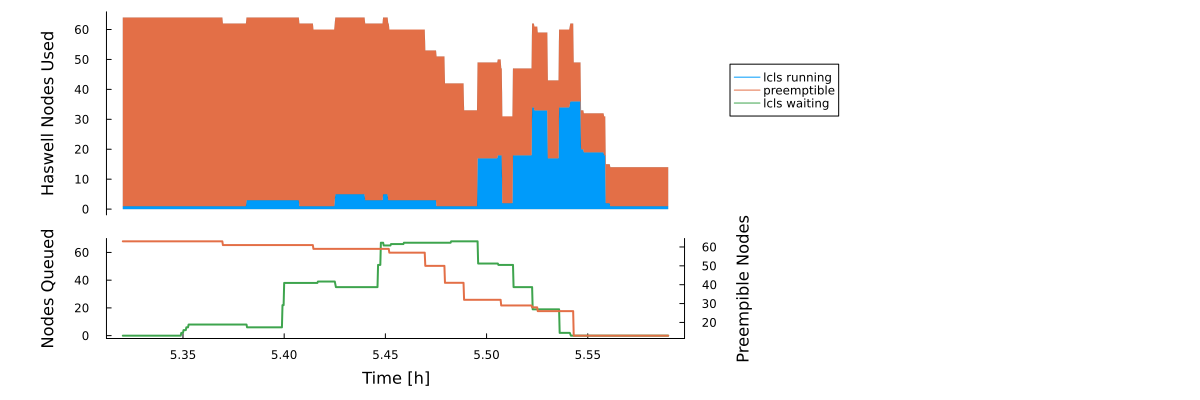

In [25]:
res = "lv07_3"
h1  = h_lcls[res]
h1s = h_nstaff[res]
h1o = h_other[res]

stack_plot(h1, h1s, h1o, (5.32, 5.59))